In [1]:
from scipy import stats 
import statsmodels.api as sm
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
import statsmodels.api as sm

In [2]:
import pandas as pd
from tqdm import tqdm  # Импортируем tqdm для отображения прогресса

In [3]:
import json
import math
import pandas as pd
import requests
import time
from datetime import datetime

In [4]:
# from binance.spot import Spot
from datetime import datetime, timedelta
import numpy as np

In [5]:
import pytz

## API Binance

In [6]:
from binance import Client
import pandas as pd
from datetime import datetime

# Инициализация клиента Binance
api_key = 'tjdQdCndNjOY2bQeS8Eh0KITPv5IY7XX9rw06qEIx7G4tufDwjFAATTTn9AIMQZE'
api_secret = 'ZsqZ7c5uwOdrrWBxjkIIYkP3vjKYpPCUAdbP0oY2RHm39pAIEijCzfoIkTccBReF' 
client = Client(api_key, api_secret)

In [7]:
# Функция для получения исторических данных
def fetch_hourly_data(symbol, interval, start_time, end_time=None):
    """
    Получает исторические klines (свечи) для указанного символа и временного интервала.
    
    :param symbol: Символ торговой пары (например, "BTCUSDT")
    :param interval: Интервал свечей (например, "1h" для почасовых данных)
    :param start_time: Начало периода в формате строки (например, "1 Jan, 2023")
    :param end_time: Конец периода в формате строки (если None, то используется текущее время)
    :return: DataFrame с данными
    """
    # Получение данных через API
    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_time,
        end_str=end_time
    )
    
    # Преобразование данных в DataFrame
    columns = [
        'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Close time', 'Quote asset volume', 'Number of trades',
        'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
    ]
    df = pd.DataFrame(klines, columns=columns)
    
    # Преобразование типов данных
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = df[col].astype(float)
    
    return df

## Парсинг активов

In [8]:
symbols = ["BNBUSDT", "BTCUSDT", "CAKEUSDT", "ETHUSDT",
           "LTCUSDT", "SOLUSDT", "STRKUSDT", "TONUSDT",
           "USDCUSDT", "XRPUSDT", "PEPEUSDT",
           "HBARUSDT", "APTUSDT", "LDOUSDT", "JUPUSDT"]

In [12]:
import os
from tqdm import tqdm

# Создание папки data в корне, если она не существует
data_dir = "../data"  # Относительный путь к папке data из notebooks
os.makedirs(data_dir, exist_ok=True)  # Создаем папку, если её нет

# Параметры запроса
interval = Client.KLINE_INTERVAL_1HOUR  # Почасовые данные
start_time = "1 Jan, 2021"  # Начало периода
end_time = None  # До текущего времени

# # Цикл для обработки каждой торговой пары
# for symbol in tqdm(symbols, desc="Обработка символов", unit="symbol"):
#     try:
#         # Получение данных
#         hourly_data = fetch_hourly_data(symbol, interval, start_time, end_time)

#         # Сохранение данных в CSV файл в папку data
#         output_file = os.path.join(data_dir, f"{symbol}_hourly_data.csv")  # Полный путь к файлу
#         hourly_data.to_csv(output_file, index=False)

#         print(f"Данные для {symbol} успешно сохранены в файл: {output_file}")
#     except Exception as e:
#         print(f"Ошибка при обработке {symbol}: {e}")

Обработка символов:   7%|▋         | 1/15 [00:36<08:28, 36.31s/symbol]

Данные для BNBUSDT успешно сохранены в файл: ../data\BNBUSDT_hourly_data.csv


Обработка символов:  13%|█▎        | 2/15 [01:02<06:38, 30.63s/symbol]

Данные для BTCUSDT успешно сохранены в файл: ../data\BTCUSDT_hourly_data.csv


Обработка символов:  20%|██        | 3/15 [01:30<05:50, 29.20s/symbol]

Данные для CAKEUSDT успешно сохранены в файл: ../data\CAKEUSDT_hourly_data.csv


Обработка символов:  27%|██▋       | 4/15 [01:58<05:17, 28.90s/symbol]

Данные для ETHUSDT успешно сохранены в файл: ../data\ETHUSDT_hourly_data.csv


Обработка символов:  33%|███▎      | 5/15 [02:26<04:42, 28.28s/symbol]

Данные для LTCUSDT успешно сохранены в файл: ../data\LTCUSDT_hourly_data.csv


Обработка символов:  40%|████      | 6/15 [02:52<04:08, 27.59s/symbol]

Данные для SOLUSDT успешно сохранены в файл: ../data\SOLUSDT_hourly_data.csv


Обработка символов:  47%|████▋     | 7/15 [02:59<02:48, 21.00s/symbol]

Данные для STRKUSDT успешно сохранены в файл: ../data\STRKUSDT_hourly_data.csv


Обработка символов:  53%|█████▎    | 8/15 [03:04<01:51, 15.86s/symbol]

Данные для TONUSDT успешно сохранены в файл: ../data\TONUSDT_hourly_data.csv


Обработка символов:  60%|██████    | 9/15 [03:29<01:52, 18.76s/symbol]

Данные для USDCUSDT успешно сохранены в файл: ../data\USDCUSDT_hourly_data.csv


Обработка символов:  67%|██████▋   | 10/15 [03:56<01:45, 21.07s/symbol]

Данные для XRPUSDT успешно сохранены в файл: ../data\XRPUSDT_hourly_data.csv


Обработка символов:  73%|███████▎  | 11/15 [04:08<01:13, 18.30s/symbol]

Данные для PEPEUSDT успешно сохранены в файл: ../data\PEPEUSDT_hourly_data.csv


Обработка символов:  80%|████████  | 12/15 [04:36<01:04, 21.44s/symbol]

Данные для HBARUSDT успешно сохранены в файл: ../data\HBARUSDT_hourly_data.csv


Обработка символов:  87%|████████▋ | 13/15 [04:52<00:39, 19.69s/symbol]

Данные для APTUSDT успешно сохранены в файл: ../data\APTUSDT_hourly_data.csv


Обработка символов:  93%|█████████▎| 14/15 [05:12<00:19, 19.76s/symbol]

Данные для LDOUSDT успешно сохранены в файл: ../data\LDOUSDT_hourly_data.csv


Обработка символов: 100%|██████████| 15/15 [05:20<00:00, 21.37s/symbol]

Данные для JUPUSDT успешно сохранены в файл: ../data\JUPUSDT_hourly_data.csv


In [13]:
import os
import pandas as pd
from tqdm import tqdm


# Функция для получения последней даты из CSV файла
def get_last_date_from_csv(file_path):
    try:
        # Читаем только первую и последнюю строку файла для определения последней даты
        df = pd.read_csv(file_path, usecols=["Open time"], parse_dates=["Open time"])
        last_date = df["Open time"].iloc[-1]
        return last_date
    except Exception as e:
        print(f"Ошибка при чтении файла {file_path}: {e}")
        return None

# Цикл для обработки всех CSV файлов
for file_name in tqdm(os.listdir(data_dir), desc="Обновление данных", unit="file"):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_dir, file_name)
        symbol = file_name.split("_")[0]  # Получаем символ из имени файла (например, BTCUSDT)

        # Получаем последнюю дату из файла
        last_date = get_last_date_from_csv(file_path)
        if last_date is None:
            print(f"Пропуск файла {file_name}: не удалось определить последнюю дату.")
            continue

        # Устанавливаем начало периода для запроса новых данных
        start_time = last_date.strftime("%d %b, %Y %H:%M:%S")  # Преобразуем дату в строку
        end_time = None  # До текущего времени

        try:
            # Получение новых данных
            new_data = fetch_hourly_data(symbol, interval, start_time, end_time)

            if new_data.empty:
                print(f"Нет новых данных для {symbol}.")
                continue

            # Удаляем первую строку новых данных, так как она может дублировать последнюю строку старых данных
            new_data = new_data.iloc[1:]

            if not new_data.empty:
                # Добавляем новые данные в существующий CSV файл
                with open(file_path, "a", newline="", encoding="utf-8") as f:
                    new_data.to_csv(f, header=False, index=False)

                print(f"Файл {file_name} успешно обновлен новыми данными.")
            else:
                print(f"Нет новых данных для добавления в файл {file_name}.")

        except Exception as e:
            print(f"Ошибка при обновлении данных для {symbol}: {e}")

Обновление данных:   5%|▌         | 1/19 [00:01<00:30,  1.70s/file]

Файл APTUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  11%|█         | 2/19 [00:02<00:18,  1.10s/file]

Файл BNBUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  16%|█▌        | 3/19 [00:03<00:21,  1.32s/file]

Файл BTCUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  21%|██        | 4/19 [00:05<00:20,  1.33s/file]

Файл CAKEUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  26%|██▋       | 5/19 [00:06<00:17,  1.26s/file]

Файл ETHUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  32%|███▏      | 6/19 [00:07<00:13,  1.07s/file]

Файл HBARUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  37%|███▋      | 7/19 [00:08<00:14,  1.23s/file]

Файл JUPUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  42%|████▏     | 8/19 [00:09<00:13,  1.20s/file]

Файл LDOUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  47%|████▋     | 9/19 [00:10<00:11,  1.17s/file]

Файл LTCUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  58%|█████▊    | 11/19 [00:11<00:06,  1.29file/s]

Файл PEPEUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  63%|██████▎   | 12/19 [00:12<00:05,  1.33file/s]

Файл SOLUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  68%|██████▊   | 13/19 [00:12<00:04,  1.39file/s]

Файл STRKUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  74%|███████▎  | 14/19 [00:13<00:03,  1.43file/s]

Файл TONUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных:  79%|███████▉  | 15/19 [00:14<00:02,  1.45file/s]

Файл USDCUSDT_hourly_data.csv успешно обновлен новыми данными.


Обновление данных: 100%|██████████| 19/19 [00:14<00:00,  1.27file/s]

Файл XRPUSDT_hourly_data.csv успешно обновлен новыми данными.


In [14]:
import os
import pandas as pd
from tqdm import tqdm

# Путь к папке с данными
data_dir = "../data"

# Создаем пустой DataFrame для объединения данных
combined_data = pd.DataFrame()

# Оборачиваем symbols в tqdm для отображения прогресса
for symbol in tqdm(symbols, desc="Обработка символов", unit="symbol"):
    csv_file = os.path.join(data_dir, f"{symbol}_hourly_data.csv")  # Полный путь к CSV файлу
    if not os.path.exists(csv_file):
        print(f"Файл {csv_file} не найден. Пропускаем символ {symbol}.")
        continue

    try:
        # Читаем данные из файла
        df = pd.read_csv(csv_file)
        df['Close time'] = pd.to_datetime(df['Close time'])  # Преобразуем 'Close time' в datetime
        df = df[['Close time', 'Close']]  # Оставляем только нужные колонки
        df.rename(columns={'Close': symbol}, inplace=True)  # Переименовываем колонку 'Close' в название символа
        df.set_index('Close time', inplace=True)  # Устанавливаем 'Close time' как индекс

        # Объединяем данные
        if combined_data.empty:
            combined_data = df
        else:
            combined_data = combined_data.join(df, how='outer')

    except Exception as e:
        print(f"Ошибка при обработке файла {csv_file}: {e}")

# Заполняем пропущенные значения методом forward fill
if not combined_data.empty:
    combined_data.fillna(method='ffill', inplace=True)

# Сохраняем объединенные данные в CSV-файл в папку data
output_file = os.path.join(data_dir, "data_compare_eda.csv")  # Полный путь к выходному файлу
combined_data.to_csv(output_file)

print(f"Объединенные данные успешно сохранены в файл: {output_file}")

Обработка символов: 100%|██████████| 15/15 [00:01<00:00, 14.74symbol/s]
C:\Users\igora\AppData\Local\Temp\ipykernel_16420\1649077532.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)


Объединенные данные успешно сохранены в файл: ../data\data_compare_eda.csv


In [15]:
combined_data

,BNBUSDT,BTCUSDT,CAKEUSDT,ETHUSDT,LTCUSDT,SOLUSDT,STRKUSDT,TONUSDT,USDCUSDT,XRPUSDT,PEPEUSDT,HBARUSDT,APTUSDT,LDOUSDT,JUPUSDT
Close time,,,,,,,,,,,,,,,
2021-01-01 00:59:59.999,37.3764,28995.13,NaN,734.07,123.87,1.5442,NaN,NaN,0.9983,0.22162,NaN,0.03198,NaN,NaN,NaN
2021-01-01 01:59:59.999,37.6134,29409.99,NaN,748.28,131.70,1.5734,NaN,NaN,0.9982,0.22382,NaN,0.03208,NaN,NaN,NaN
2021-01-01 02:59:59.999,37.9600,29194.65,NaN,744.06,133.33,1.5872,NaN,NaN,0.9982,0.22361,NaN,0.03215,NaN,NaN,NaN
2021-01-01 03:59:59.999,37.9250,29278.40,NaN,744.82,131.66,1.6029,NaN,NaN,0.9981,0.22730,NaN,0.03222,NaN,NaN,NaN
2021-01-01 04:59:59.999,37.8702,29220.31,NaN,742.29,130.87,1.6022,NaN,NaN,0.9982,0.23898,NaN,0.03327,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-03 12:59:59.999,597.2800,96120.42,2.004,1829.59,86.61,148.0900,0.1348,3.175,0.9997,2.19700,0.000008,0.18246,5.239,0.823,0.4427
2025-05-03 13:59:59.999,597.9100,96330.00,2.010,1835.20,86.95,148.4200,0.1339,3.171,0.9997,2.20280,0.000008,0.18322,5.223,0.826,0.4434
2025-05-03 14:59:59.999,598.0000,96380.95,2.006,1835.20,87.12,148.4900,0.1347,3.170,0.9998,2.21150,0.000008,0.18368,5.237,0.826,0.4435


In [13]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37857 entries, 2021-01-01 00:59:59.999000 to 2025-04-26 15:59:59.999000
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BNBUSDT   37857 non-null  float64
 1   BTCUSDT   37857 non-null  float64
 2   CAKEUSDT  36669 non-null  float64
 3   ETHUSDT   37857 non-null  float64
 4   LTCUSDT   37857 non-null  float64
 5   SOLUSDT   37857 non-null  float64
 6   STRKUSDT  10347 non-null  float64
 7   TONUSDT   6270 non-null   float64
 8   USDCUSDT  37857 non-null  float64
 9   XRPUSDT   37857 non-null  float64
 10  PEPEUSDT  17326 non-null  float64
 11  HBARUSDT  37857 non-null  float64
 12  APTUSDT   22104 non-null  float64
 13  LDOUSDT   26006 non-null  float64
 14  JUPUSDT   10824 non-null  float64
dtypes: float64(15)
memory usage: 4.6 MB


## Визуализация активов

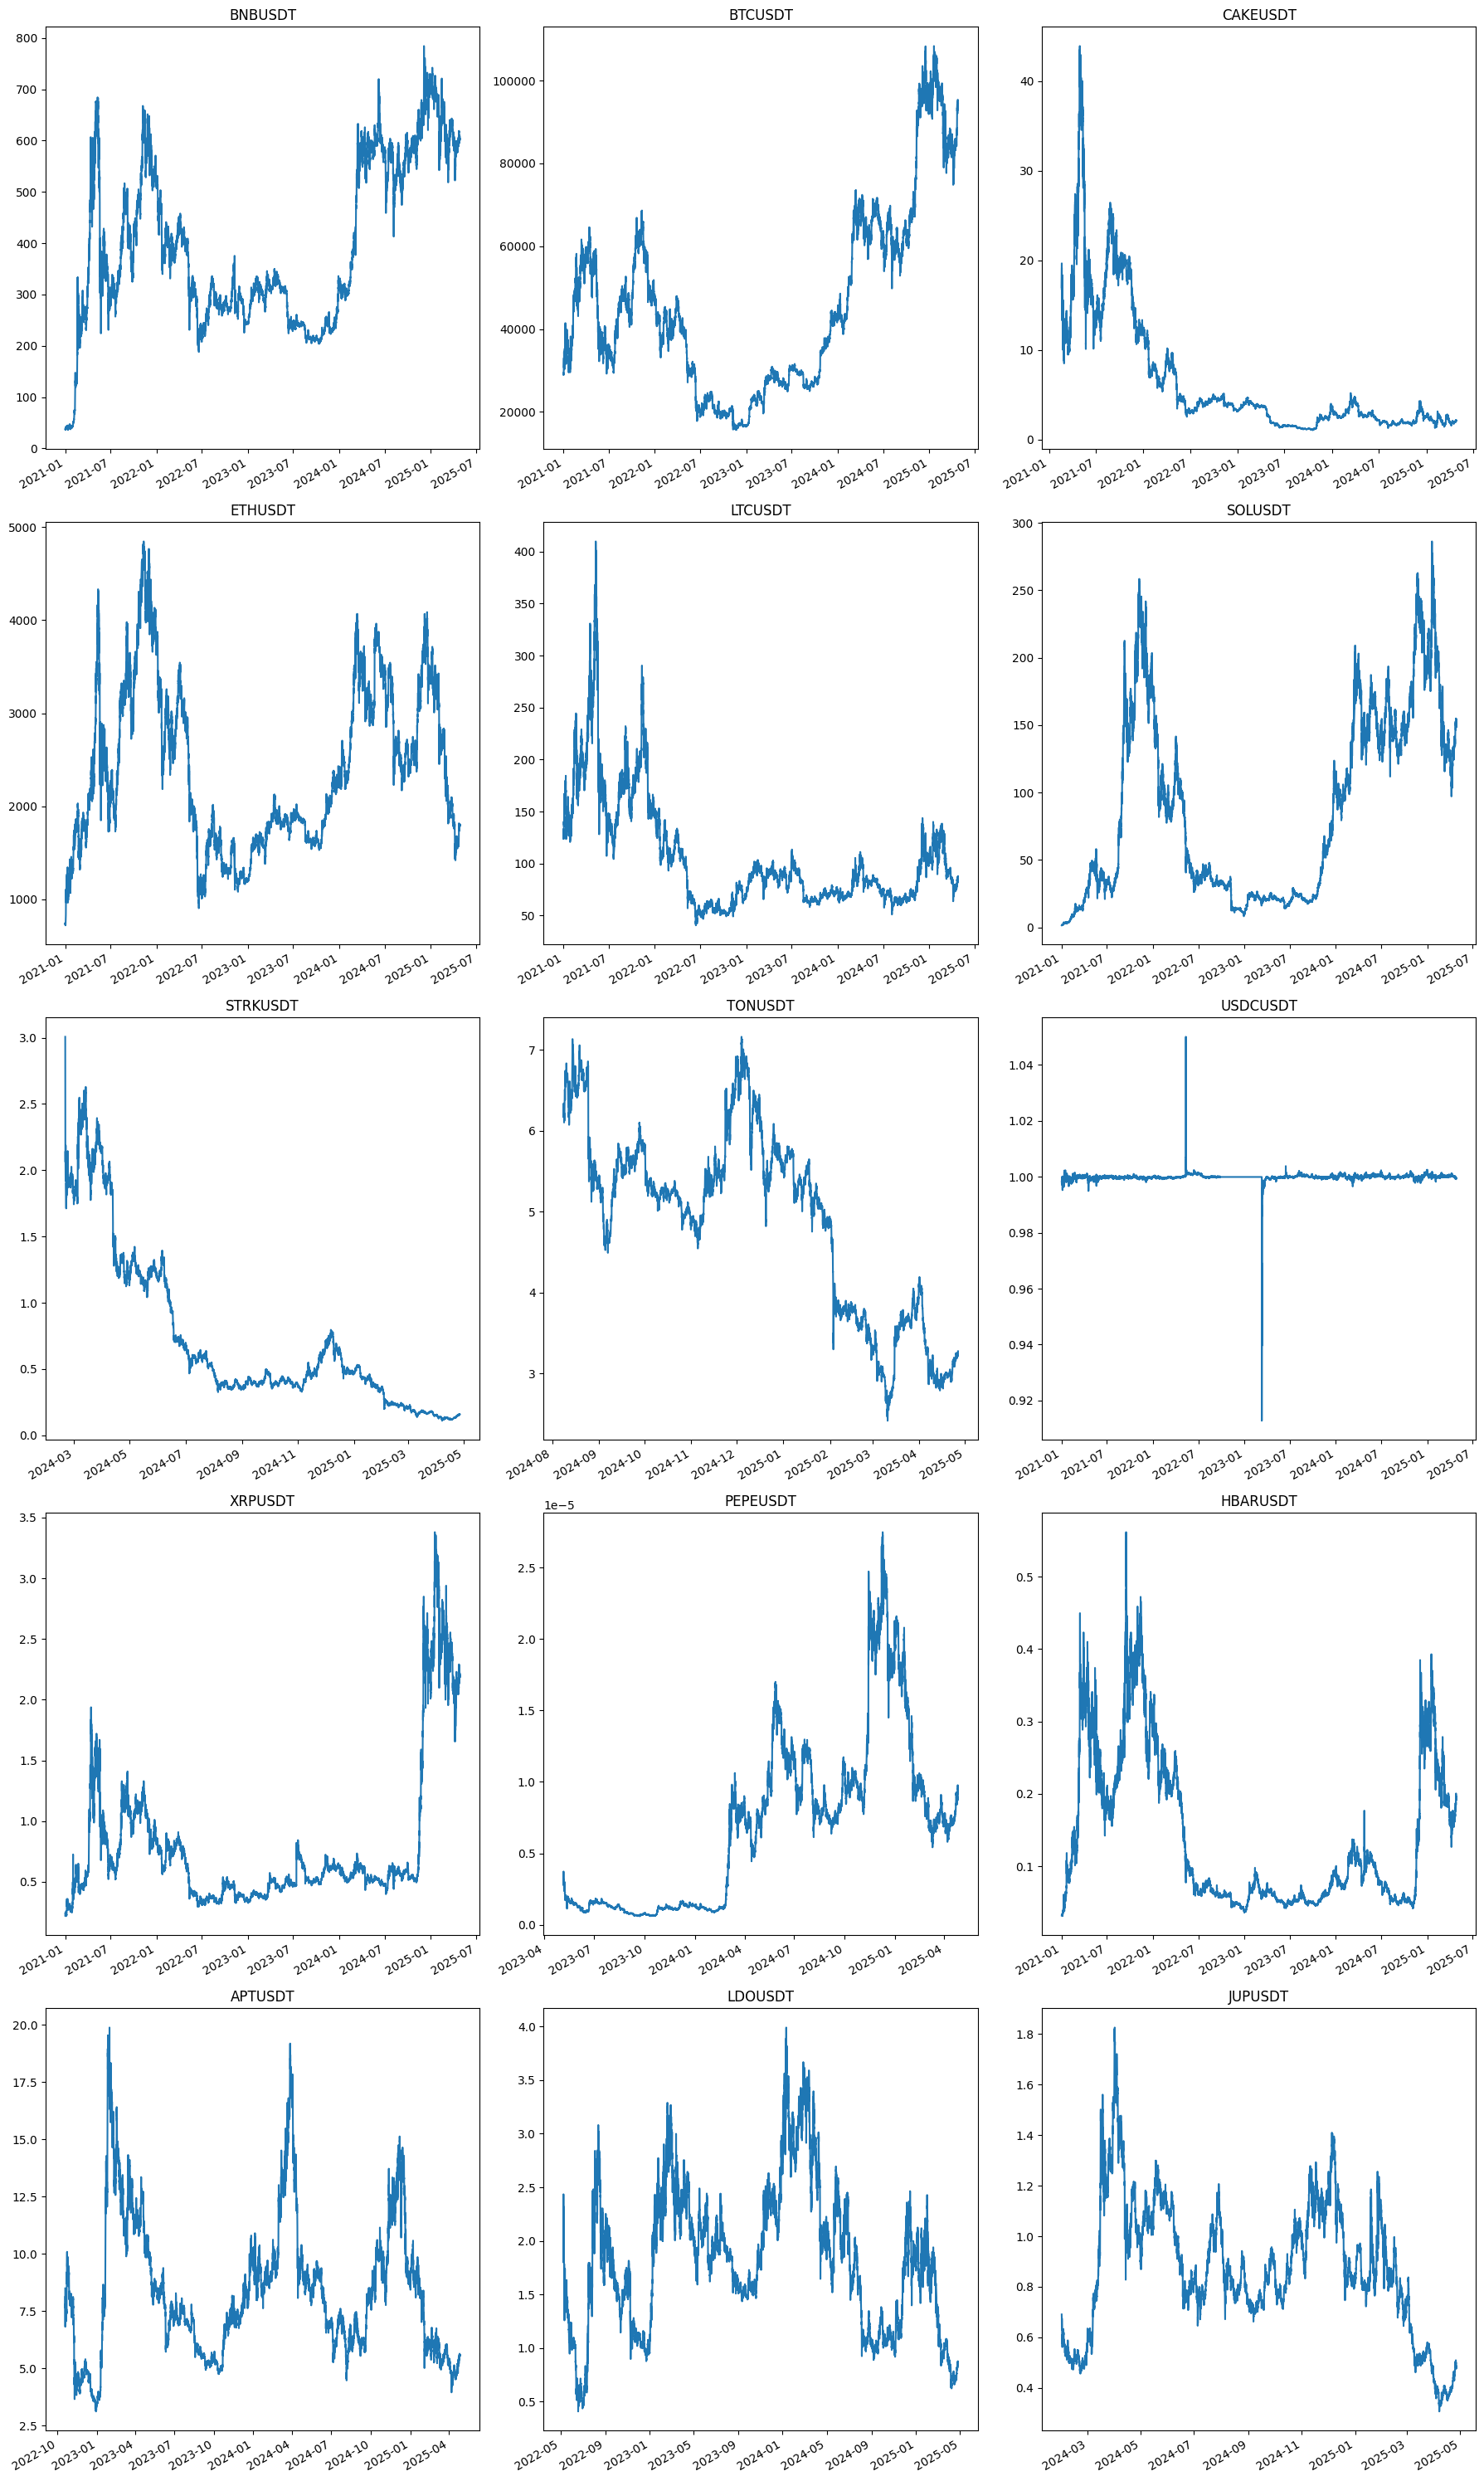

In [14]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns for the grid
num_columns = len(combined_data.columns)
rows = (num_columns + 2) // 3  # Ensure enough rows for 3 columns per row
cols = 3

plt.figure(figsize=(18, 6 * rows))  # Adjust figure size dynamically
plt.subplots_adjust(top=1)

for i, company in enumerate(combined_data.columns, 1):
    plt.subplot(rows, cols, i)
    combined_data[company].plot()
    plt.xlabel(None)
    plt.title(company)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [15]:
combined_data.describe()

,BNBUSDT,BTCUSDT,CAKEUSDT,ETHUSDT,LTCUSDT,SOLUSDT,STRKUSDT,TONUSDT,USDCUSDT,XRPUSDT,PEPEUSDT,HBARUSDT,APTUSDT,LDOUSDT,JUPUSDT
count,37857.000000,37857.000000,36669.000000,37857.000000,37857.000000,37857.000000,10347.000000,6270.000000,37857.000000,37857.000000,1.732600e+04,37857.000000,22104.000000,26006.000000,10824.000000
mean,396.621511,46177.872693,6.432839,2403.785954,106.101221,87.129200,0.727871,4.889708,0.999860,0.787312,6.911622e-06,0.141020,8.373793,1.823642,0.872462
std,159.720700,22245.877992,6.981009,859.783793,52.839233,69.429224,0.601245,1.149779,0.001679,0.589607,6.013926e-06,0.104717,2.980852,0.664933,0.258887
min,35.875600,15649.520000,1.052000,719.900000,40.600000,1.544200,0.110500,2.416000,0.912800,0.217430,6.100000e-07,0.031100,3.114900,0.408000,0.306800
25%,274.500000,27933.150000,2.076000,1697.930000,69.110000,23.990000,0.366000,3.761250,0.999600,0.468470,1.240000e-06,0.059300,6.090000,1.281000,0.733800
50%,338.600000,42012.940000,3.506000,2247.410000,88.100000,58.460000,0.468700,5.216000,0.999900,0.566200,7.170000e-06,0.086900,7.930000,1.824500,0.855600
75%,558.200000,60924.000000,7.820000,3110.400000,127.640000,144.710000,1.132000,5.641000,1.000100,0.823200,9.840000e-06,0.215590,9.730000,2.249000,1.058825
max,784.200000,108320.010000,43.892000,4846.710000,409.840000,286.240000,3.007000,7.162000,1.050000,3.380500,2.747000e-05,0.561700,19.888000,3.991000,1.826100


## Визуализация нормализованных активов за последние N дней

In [ ]:
N_days = 120

# Определяем количество записей за последние 120 дней (120 дней * 24 часа)
last_120_days_records = N_days * 24

# Выбираем последние 2880 записей (последние 120 дней)
recent_data = combined_data.tail(last_120_days_records)

# Нормализуем данные за последние 120 дней
normalized_recent_data = (
    recent_data.drop(["USDCUSDT"], axis=1) - 
    recent_data.drop(["USDCUSDT"], axis=1).mean()
) / recent_data.drop(["USDCUSDT"], axis=1).std()

# Строим график
plt.figure(figsize=(14, 7))
for column in normalized_recent_data.columns:
    plt.plot(normalized_recent_data.index, normalized_recent_data[column], label=column)

plt.title("Normalized Close Prices of Cryptocurrencies (Last 120 Days)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.show()

## Визуализация нормализованных активов за все время

In [ ]:
normalized_data = (combined_data.drop(["USDCUSDT"], axis=1) - combined_data.drop(["USDCUSDT"], axis=1).mean()) / combined_data.drop(["USDCUSDT"], axis=1).std()

plt.figure(figsize=(14, 7))
for column in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[column], label=column)

plt.title("Normalized Close Prices of Cryptocurrencies")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import plotly.express as px

# Создаем box plot для нормализованных данных
fig = px.box(normalized_data, 
             title="Box Plot of Normalized Cryptocurrency Prices (Weekly Data)",
             labels={"value": "Normalized Price", "variable": "Cryptocurrency"},
             template="plotly_white")

# Настройка внешнего вида
fig.update_layout(
    autosize=False,
    width=800,  # ширина графика
    height=400,  # высота графика
    margin=dict(l=50, r=50, b=50, t=50, pad=4),
    font=dict(size=12),
    showlegend=False
)

# Отображаем график
fig.show()

In [ ]:
normalized_data

## Оценим распределения активов по неделям

In [ ]:
# Определяем начальную дату
start_date = "2023-01-01"

# Выбираем данные, начиная с 2023-01-01
filtered_data = combined_data.loc[start_date:]
filtered_data = filtered_data[~filtered_data.index.duplicated(keep='last')]

# Ресемплируем данные по неделям и заполняем пропуски методом forward fill
weekly_data = filtered_data.drop(["USDCUSDT"], axis=1).resample('W').ffill()

# Рассчитываем процентные изменения для недельных данных
weekly_pct_change = weekly_data.pct_change()

# Фильтруем активы, у которых есть хотя бы несколько значений (исключаем активы без достаточных данных)
min_valid_values = 2  # Минимальное количество значений для анализа
valid_assets = weekly_pct_change.columns[weekly_pct_change.count() >= min_valid_values]
weekly_pct_change = weekly_pct_change[valid_assets]

# Строим гистограмму распределения недельных процентных изменений
weekly_pct_change.plot.hist(stacked=True, bins=40, figsize=(12, 8), alpha=0.7, grid=True)

# Настройка графика
plt.title("Distribution of Weekly Percentage Changes (From 2023-01-01)", fontsize=16)
plt.xlabel("Weekly Percentage Change", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(loc="upper right")
plt.show()

In [ ]:
weekly_pct_change.plot.bar(stacked=True, figsize=(21, 8))
#plt.axis('off')
plt.show()

In [ ]:
corr_pct_m = weekly_pct_change.corr()

styled_corr = (
    corr_pct_m.style
    .background_gradient(cmap='coolwarm') 
    .format("{:.2f}")                  
)

display(styled_corr)

## Обор активов с минимальной корреляцией

In [ ]:
import pandas as pd

# Предположим, что weekly_pct_change — это DataFrame с недельными процентными изменениями
corr_pct_m = weekly_pct_change.corr()

# Преобразуем матрицу корреляций в формат длинной таблицы
corr_long = (
    corr_pct_m
    .reset_index()  # Добавляем индекс как столбец
    .melt(id_vars="index", var_name="Asset2", value_name="Correlation")  # Преобразуем в длинный формат
    .rename(columns={"index": "Asset1"})  # Переименовываем столбец
)

# Удаляем дубликаты и диагональные значения (где Asset1 == Asset2)
corr_long = corr_long[
    (corr_long["Asset1"] != corr_long["Asset2"])  # Исключаем диагональ
].drop_duplicates(subset=["Correlation"])  # Удаляем дубликаты (если есть)

# Сортируем по возрастанию корреляции
corr_sorted = corr_long.sort_values(by="Correlation", ascending=True)

# Если хотите стилизовать результат:
styled_corr_sorted = (
    corr_sorted.style
    .background_gradient(cmap='coolwarm', subset=["Correlation"])  # Градиент для столбца Correlation
    .format({"Correlation": "{:.2f}"})  # Форматирование значений корреляции
)

display(styled_corr_sorted)

In [ ]:
import pandas as pd

# Предположим, что corr_sorted уже создан и содержит отсортированные пары активов
# corr_sorted = corr_long.sort_values(by="Correlation", ascending=True)

def select_portfolio(corr_sorted, max_assets=5):
    portfolio = []  # Список выбранных активов
    used_assets = set()  # Множество для отслеживания уже добавленных активов
    
    for _, row in corr_sorted.iterrows():
        asset1, asset2, correlation = row["Asset1"], row["Asset2"], row["Correlation"]
        
        # Если оба актива еще не в портфеле, добавляем их
        if len(portfolio) == 0:
            # Первые два актива всегда добавляем
            portfolio.append(asset1)
            portfolio.append(asset2)
            used_assets.update([asset1, asset2])
        elif asset1 not in used_assets and asset2 not in used_assets:
            # Проверяем корреляцию нового актива со всеми активами в портфеле
            avg_corr = sum(
                corr_sorted.loc[
                    (corr_sorted["Asset1"] == asset1) & (corr_sorted["Asset2"].isin(portfolio)), "Correlation"
                ].tolist()
            ) / len(portfolio)
            
            if avg_corr < 0.5:  # Добавляем только если средняя корреляция ниже порога
                portfolio.append(asset1)
                used_assets.add(asset1)
        
        # Останавливаемся, если достигли максимального количества активов
        if len(portfolio) >= max_assets:
            break
    
    return portfolio

# Выбор портфеля
selected_portfolio = select_portfolio(corr_sorted, max_assets=7)
print("Selected Portfolio:", selected_portfolio)

In [ ]:
# Определяем начальную дату
start_date = "2023-01-01"

# Выбираем данные, начиная с 2023-01-01
filtered_data = combined_data.loc[start_date:]
filtered_data = filtered_data[~filtered_data.index.duplicated(keep='last')]

# Ресемплируем данные по неделям и заполняем пропуски методом forward fill
weekly_data = filtered_data[selected_portfolio].resample('W').ffill()

# Рассчитываем процентные изменения для недельных данных
weekly_pct_change = weekly_data.pct_change()

# Фильтруем активы, у которых есть хотя бы несколько значений (исключаем активы без достаточных данных)
min_valid_values = 2  # Минимальное количество значений для анализа
valid_assets = weekly_pct_change.columns[weekly_pct_change.count() >= min_valid_values]
weekly_pct_change = weekly_pct_change[valid_assets]

# Строим гистограмму распределения недельных процентных изменений
weekly_pct_change.plot.hist(stacked=True, bins=40, figsize=(12, 8), alpha=0.7, grid=True)

# Настройка графика
plt.title("Distribution of Weekly Percentage Changes (From 2023-01-01)", fontsize=16)
plt.xlabel("Weekly Percentage Change", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(loc="upper right")
plt.show()

In [ ]:
weekly_pct_change.plot.bar(stacked=True, figsize=(21, 8))
#plt.axis('off')
plt.show()

In [ ]:
corr_pct_m = weekly_pct_change.corr()

styled_corr = (
    corr_pct_m.style
    .background_gradient(cmap='coolwarm') 
    .format("{:.2f}")                  
)

display(styled_corr)

In [ ]:
print(selected_portfolio)

In [31]:
# selected_portfolio.remove('HBARUSDT')

In [ ]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Настройка стиля графиков
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(12, 8))
plt.rc("font", size=13)

# Агрегация данных: усреднение по неделям
weekly_data = combined_data[selected_portfolio].resample('W').mean()

# Определяем начальную дату
start_date = "2023-01-01"

# Фильтрация данных, начиная с start_date
filtered_data = weekly_data.loc[start_date:]

# Применение STL-декомпозиции для каждой криптовалюты
for asset in filtered_data.columns:
    # Проверяем, что у актива есть достаточное количество данных
    if filtered_data[asset].count() >= 7:  # Минимум 7 точек для декомпозиции
        # Создание и обучение STL-модели
        stlModel = STL(filtered_data[asset].dropna(), robust=True, period=7).fit()  # period=7 для недельной сезонности
        
        # Вывод названия актива
        print(f"STL Decomposition for {asset}")
        
        # Построение графика (без observed и resid компонент)
        fig = stlModel.plot(observed=False, resid=False)
        plt.show()
        
        # Получение остатков из STL-модели
        residuals = stlModel.resid
        
        # Построение графика остатков
        plt.figure(figsize=(12, 6))
        plt.plot(residuals, label="Residuals", color="gray", alpha=0.7)
        plt.title(f"Residuals from STL Decomposition ({asset})")
        plt.xlabel("Date")
        plt.ylabel("Residual Value")
        plt.axhline(0, color="red", linestyle="--", linewidth=1)  # Линия для нулевых остатков
        plt.legend()
        plt.grid()
        plt.show()
        
        # График автокорреляции остатков
        plt.figure(figsize=(12, 6))
        plot_acf(residuals.dropna(), lags=30, ax=plt.gca())  # Убираем NaN перед построением ACF
        plt.title(f"Autocorrelation of Residuals ({asset})")
        plt.show()
    else:
        print(f"Not enough data for {asset} to perform STL decomposition.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Настройка стиля графиков
sns.set_style("darkgrid")
plt.rc("figure", figsize=(18, 12))
plt.rc("font", size=12)

# Функция для построения графиков автокорреляции
def plot_autocorrelation(data):
    """
    Строит графики автокорреляции для всех столбцов в DataFrame.
    :param data: DataFrame с временными рядами
    """
    # Определение количества строк и столбцов для подграфиков
    num_assets = len(data.columns)
    num_cols = 3  # Количество столбцов в сетке
    num_rows = (num_assets + num_cols - 1) // num_cols  # Количество строк
    
    # Создание фигуры с подграфиками
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    axes = axes.flatten()  # Преобразование массива в одномерный для удобства
    
    # Построение графиков автокорреляции
    for i, asset in enumerate(data.columns):
        pd.plotting.autocorrelation_plot(data[asset].dropna(), ax=axes[i])  # Удаляем NaN перед построением
        axes[i].set_title(asset, fontsize=14, fontweight="bold")  # Заголовок графика
        axes[i].set_xlabel("Lag", fontsize=12)  # Подпись оси X
        axes[i].set_ylabel("Autocorrelation", fontsize=12)  # Подпись оси Y
        axes[i].grid(True, linestyle="--", alpha=0.7)  # Сетка
    
    # Удаление пустых подграфиков
    for j in range(num_assets, len(axes)):
        axes[j].axis("off")
    
    # Настройка общего заголовка
    fig.suptitle("Autocorrelation Plots for All Assets", fontsize=18, fontweight="bold", y=1.02)
    
    # Отображение графиков
    plt.tight_layout()
    plt.show()

# Определяем начальную дату
start_date = "2023-01-01"

# Агрегация данных: усреднение по неделям
weekly_data = combined_data[selected_portfolio].resample('W').mean()

# Фильтрация данных, начиная с start_date
filtered_data = weekly_data.loc[start_date:]

# Вызов функции для данных
plot_autocorrelation(filtered_data)